In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [22]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE

In [23]:
# Load dataset
df = pd.read_csv('sd.csv')  # Ensure this file exists in the working directory

X = df['text']
y = df['task_1']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(label_encoder.classes_)

['HOF' 'NOT']


In [24]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # URLs
    text = re.sub(r"\d+", "", text)             # numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

X_clean = X.apply(clean_text)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)


TF-IDF FEATURE EXTRACTION


In [25]:
tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    min_df=3,
    max_features=50000,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(
    X_train_tfidf,
    y_train
)

print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE :", pd.Series(y_train_smote).value_counts())

Logistic Regression Model

Accuracy : 0.6881
Precision: 0.6352
Recall   : 0.5976
F1 Score : 0.6159
----------------------------------------


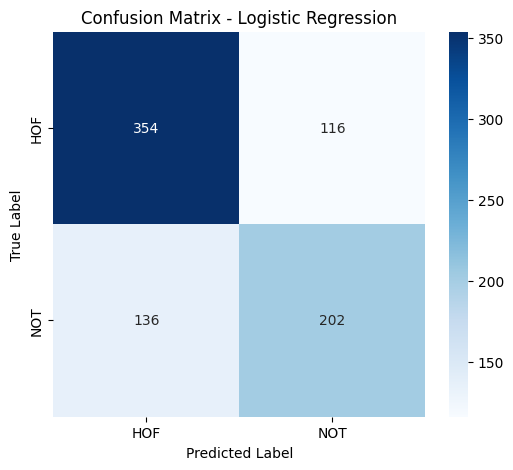

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lr = LogisticRegression(
    class_weight='balanced',
    max_iter=3000
)

# Hyperparameter Grid
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 50],
    'solver': ['liblinear']
}

# GridSearch with F1-score
lr_grid = GridSearchCV(
    lr,
    lr_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Train on SMOTE-balanced data
lr_grid.fit(X_train_smote, y_train_smote)

# Best model
best_lr = lr_grid.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred_lr)
prec = precision_score(y_test, y_pred_lr)
rec = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

# Print metrics (BiLSTM-style output)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("-" * 40)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
